In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation
import gensim
import smart_open
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import re
from tqdm import tqdm_notebook #for parallel processing
from nltk import word_tokenize
from fuzzywuzzy import fuzz
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve



In [5]:
df=pd.read_csv('/Users/srishtysuman/PycharmProjects/NaturalLanguageProcessing/quora-question-pairs/train.csv')
df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [6]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [7]:
df.dropna(how="any", inplace=True)

In [8]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

<Axes: xlabel='is_duplicate'>

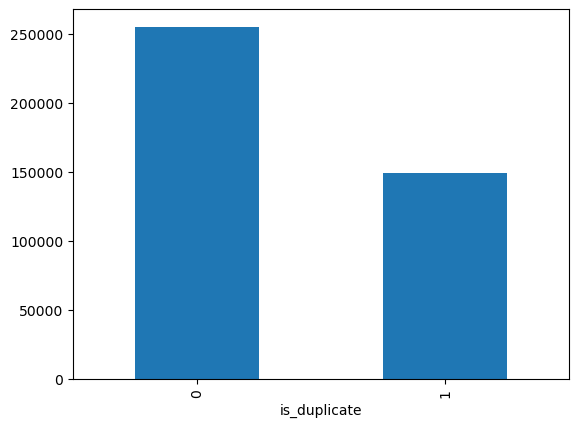

In [9]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [10]:
count_labels=df.groupby('is_duplicate')['id'].count()
count_labels

is_duplicate
0    255024
1    149263
Name: id, dtype: int64

In [11]:
count_labels[0]/sum(count_labels)

0.630799407351708

In [12]:
count_labels[1]/sum(count_labels)

0.3692005926482919

In [13]:
df['is_duplicate'].value_counts(normalize = True)

is_duplicate
0    0.630799
1    0.369201
Name: proportion, dtype: float64

In [14]:
len(df["qid1"].tolist())

404287

In [15]:
len(df["qid2"].tolist())

404287

In [16]:
# no. of unique questions
qids=pd.Series(df["qid1"].tolist()+df["qid2"].tolist())
len(np.unique(qids))

537929

In [17]:
np.sum(qids.value_counts()>1)

111778

In [18]:
qids

0              1
1              3
2              5
3              7
4              9
           ...  
808569    379845
808570    155606
808571    537929
808572    537931
808573    537933
Length: 808574, dtype: int64

In [19]:
qids.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Name: count, Length: 537929, dtype: int64

In [20]:
max(qids.value_counts())

157

In [21]:
df[['qid1','qid2','is_duplicate']]

,qid1,qid2,is_duplicate
0,1,2,0
1,3,4,0
2,5,6,0
3,7,8,0
4,9,10,0
...,...,...,...
404285,433578,379845,0
404286,18840,155606,1
404287,537928,537929,0
404288,537930,537931,0


In [22]:
pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()
pair_duplicates

,qid1,qid2,is_duplicate
0,1,2,1
1,3,4,1
2,3,282170,1
3,3,380197,1
4,3,488853,1
...,...,...,...
404282,537924,537925,1
404283,537926,537927,1
404284,537928,537929,1
404285,537930,537931,1


In [23]:
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 157



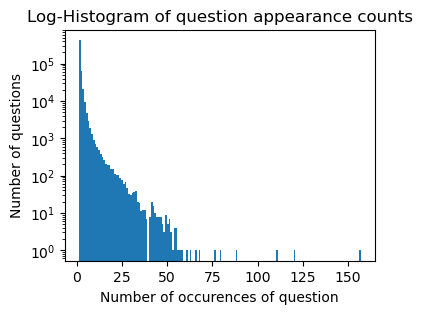

In [24]:
#Number of occurrences of each question

plt.figure(figsize=(4, 3))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [25]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [26]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}


In [27]:
# import nltk  
# nltk.download()

In [28]:
stop_words = stopwords.words('english')

' '.join([word for word in "discuss some common symbols and their meanings in regular expressions".split(" ") if word not in stop_words]).lower()

'discuss common symbols meanings regular expressions'

In [29]:

stop_words = stopwords.words('english')

def clean(text, stem_words=True):  
    if pd.isnull(text):
        return ''

    if type(text) != str or text=='':
        return ''
    
    text = re.sub("\'s", " ", text) 
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    # Return a list of words
    text = ' '.join([word for word in text.split(" ") if word not in stop_words]).lower()
    #text = ' '.join([ps.stem(word) for word in text])
    return text

In [30]:
df['question1']

0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
404285    How many keywords are there in the Racket prog...
404286            Do you believe there is life after death?
404287                                    What is one coin?
404288    What is the approx annual cost of living while...
404289                What is like to have sex with cousin?
Name: question1, Length: 404287, dtype: object

In [31]:
df['question1'] = df['question1'].apply(lambda x: clean(x))
df['question1']


0           what step step guide invest share market india?
1                 what story kohinoor (koh-i-noor) diamond?
2         how i increase speed internet connection using...
3                    why i mentally lonely? how i solve it?
4         which one dissolve water quikly sugar, salt, m...
                                ...                        
404285    how many keywords racket programming language ...
404286                               do believe life death?
404287                                       what one coin?
404288    what approx annual cost living studying uic ch...
404289                                what like sex cousin?
Name: question1, Length: 404287, dtype: object

In [32]:
df['question2'] = df['question2'].apply(lambda x: clean(x))
df['question2']

0                 what step step guide invest share market?
1         what would happen indian government stole kohi...
2                 how internet speed increased hacking dns?
3         find remainder [math]23^{24}[/math] divided 2423?
4                      which fish would survive salt water?
                                ...                        
404285    how many keywords perl programming language la...
404286                                  is true life death?
404287                                          what  coin?
404288    i little hairfall problem i want use hair styl...
404289                                what like sex cousin?
Name: question2, Length: 404287, dtype: object

In [33]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0


In [34]:
# # https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
# model

In [35]:
question1_vectors = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 1
question1_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
question1_vectors[0,]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
len(question1_vectors[0,])

300

In [38]:
len(question1_vectors)

404287

In [39]:
question2_vectors  = np.zeros((df.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 2
question2_vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
df.question1.values

array(['what step step guide invest share market india?',
       'what story kohinoor (koh-i-noor) diamond?',
       'how i increase speed internet connection using vpn?', ...,
       'what one coin?',
       'what approx annual cost living studying uic chicago, indian student?',
       'what like sex cousin?'], dtype=object)

In [41]:
str("Filter out non-alpha characters?").lower()

'filter out non-alpha characters?'

In [42]:
words=word_tokenize("filter out non-alpha characters?")
words

['filter', 'out', 'non-alpha', 'characters', '?']

In [43]:

words=[w for w in words if not w in stop_words]
words

['filter', 'non-alpha', 'characters', '?']

In [44]:
words = [w for w in words if w.isalpha()]
words

['filter', 'characters']

In [45]:
M=[]
for w in words:
    M.append(np.random.rand(300,1))
M


[array([[0.56016327],
        [0.47256885],
        [0.55378217],
        [0.84287413],
        [0.38991736],
        [0.40171089],
        [0.02045121],
        [0.74498623],
        [0.23566713],
        [0.16628008],
        [0.77127951],
        [0.34865205],
        [0.43485797],
        [0.12269254],
        [0.24453239],
        [0.03446303],
        [0.87349768],
        [0.24942289],
        [0.88892354],
        [0.95670345],
        [0.27902193],
        [0.75152386],
        [0.08082881],
        [0.99950982],
        [0.23450677],
        [0.02920425],
        [0.24347423],
        [0.60420166],
        [0.83800114],
        [0.38399787],
        [0.39850844],
        [0.72713479],
        [0.71299414],
        [0.6993311 ],
        [0.27816612],
        [0.36696167],
        [0.43148782],
        [0.85677945],
        [0.89948402],
        [0.97237937],
        [0.02880046],
        [0.84694571],
        [0.38247521],
        [0.10829334],
        [0.38832401],
        [0

In [48]:
def sent2vec(s):
    words = str(s).lower() #lower the sentence
    words = word_tokenize(words) #tokenize the sentence
    words = [w for w in words if not w in stop_words] #Filter out the stop words
    words = [w for w in words if w.isalpha()] #Filter out non-alpha characters
    M = []
    for w in words:#loop through each word in the sentence
        try:
            M.append(model[w])#Gensim model converts each word in the sentence to a 300-dim vector space and appends to a list.
        except:
            M.append(np.random.rand(300,))
            continue
    M = np.array(M) #convert the list to array. Shape = (num_of_words_in_sentence,300)
    v = M.sum(axis=0) #Sum up along the num_of_words_in_sentence through 300-dim. Shape = (1,300) 
    return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum

In [49]:
for i, q in enumerate(tqdm_notebook(df.question1.values)):
    question1_vectors[i, :] = sent2vec(q) #function call for each question 1

/var/folders/g9/56rlvw7s6w54xn7rhdmb0qlw0000gn/T/ipykernel_21354/2695449222.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, q in enumerate(tqdm_notebook(df.question1.values)):


  0%|          | 0/404287 [00:00<?, ?it/s]

/var/folders/g9/56rlvw7s6w54xn7rhdmb0qlw0000gn/T/ipykernel_21354/566381817.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum


In [50]:
question1_vectors

array([[0.06429772, 0.07780775, 0.04630165, ..., 0.06316529, 0.05542288,
        0.06564255],
       [0.03889464, 0.05654311, 0.05593197, ..., 0.0628937 , 0.08454528,
        0.06129988],
       [0.04115577, 0.06975249, 0.03697414, ..., 0.06015976, 0.07386871,
        0.06125017],
       ...,
       [0.01192878, 0.03726563, 0.02319141, ..., 0.07878345, 0.05438909,
        0.05765996],
       [0.04788443, 0.07088236, 0.04859849, ..., 0.05035478, 0.05024747,
        0.07352547],
       [0.0500424 , 0.09487757, 0.04410985, ..., 0.08203741, 0.04469974,
        0.08232861]])

In [53]:
for i, q in enumerate(tqdm_notebook(df["question2"].values)):
    question2_vectors[i, :] = sent2vec(q) #function call for each question 2

/var/folders/g9/56rlvw7s6w54xn7rhdmb0qlw0000gn/T/ipykernel_21354/3341986218.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, q in enumerate(tqdm_notebook(df["question2"].values)):


  0%|          | 0/404287 [00:00<?, ?it/s]

/var/folders/g9/56rlvw7s6w54xn7rhdmb0qlw0000gn/T/ipykernel_21354/566381817.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum


In [54]:
question2_vectors

array([[0.03378713, 0.06316295, 0.0681854 , ..., 0.06474605, 0.06230707,
        0.05828899],
       [0.05661834, 0.05132168, 0.05469945, ..., 0.05100467, 0.04191501,
        0.07772223],
       [0.04566698, 0.05268764, 0.03902478, ..., 0.06991031, 0.04125354,
        0.07044657],
       ...,
       [0.01254794, 0.06195862, 0.01076533, ..., 0.06673699, 0.07489915,
        0.04319951],
       [0.0555988 , 0.06608443, 0.06093714, ..., 0.06068395, 0.04811463,
        0.06378657],
       [0.01361069, 0.0478733 , 0.04879955, ..., 0.07940345, 0.07309413,
        0.04876017]])

In [55]:
df['len_q1'] = df["question1"].apply(lambda x: len(str(x)))
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69
...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61
404286,404286,18840,155606,do believe life death?,is true life death?,1,22
404287,404287,537928,537929,what one coin?,what coin?,0,14
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68


In [56]:
df['len_q2'] = df["question2"].apply(lambda x: len(str(x)))
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36
...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19
404287,404287,537928,537929,what one coin?,what coin?,0,14,11
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92


In [57]:
df['common_words'] = df.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1
...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0


In [59]:
df['fuzz_ratio'] = df.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34
...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38


In [60]:
df['fuzz_partial_ratio'] = df.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50
...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43


In [61]:
df['fuzz_partial_token_set_ratio'] = df.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98,100
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85,100
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45,100
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19,32
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50,100
...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92,100
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80,100
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73,100
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43,36


In [62]:
df['fuzz_partial_token_sort_ratio'] = df.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98,100,92
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85,100,82
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45,100,80
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19,32,29
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50,100,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92,100,88
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80,100,71
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73,100,78
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43,36,36


In [63]:
df['fuzz_token_set_ratio'] = df.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98,100,92,100
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85,100,82,91
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45,100,80,67
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19,32,29,28
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50,100,71,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92,100,88,95
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80,100,71,71
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73,100,78,100
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43,36,36,30


In [64]:
df['fuzz_token_sort_ratio'] = df.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98,100,92,100,93
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85,100,82,91,64
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45,100,80,67,67
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19,32,29,28,25
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50,100,71,63,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92,100,88,95,90
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80,100,71,71,56
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73,100,78,100,82
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43,36,36,30,30


In [66]:
question1_vectors

array([[0.06429772, 0.07780775, 0.04630165, ..., 0.06316529, 0.05542288,
        0.06564255],
       [0.03889464, 0.05654311, 0.05593197, ..., 0.0628937 , 0.08454528,
        0.06129988],
       [0.04115577, 0.06975249, 0.03697414, ..., 0.06015976, 0.07386871,
        0.06125017],
       ...,
       [0.01192878, 0.03726563, 0.02319141, ..., 0.07878345, 0.05438909,
        0.05765996],
       [0.04788443, 0.07088236, 0.04859849, ..., 0.05035478, 0.05024747,
        0.07352547],
       [0.0500424 , 0.09487757, 0.04410985, ..., 0.08203741, 0.04469974,
        0.08232861]])

In [67]:
df["q1_vector"]=list(question1_vectors)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,q1_vector
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98,100,92,100,93,"[0.06429772008493242, 0.07780775116771638, 0.0..."
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85,100,82,91,64,"[0.03889463632273166, 0.05654310850752797, 0.0..."
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45,100,80,67,67,"[0.04115577100254242, 0.06975248845138117, 0.0..."
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19,32,29,28,25,"[0.08313561440755624, 0.06448730243396433, 0.0..."
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50,100,71,63,48,"[0.04948477403123415, 0.060095905547667784, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92,100,88,95,90,"[0.03648658121408659, 0.05696797703620605, 0.0..."
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80,100,71,71,56,"[0.08722920569475938, 0.04243946120893346, 0.0..."
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73,100,78,100,82,"[0.01192877923496434, 0.03726562568298454, 0.0..."
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43,36,36,30,30,"[0.04788442899924827, 0.07088235573690452, 0.0..."


In [69]:
len(df["q1_vector"].iloc[0])

300

In [70]:
df["q2_vector"]=list(question2_vectors)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,q1_vector,q2_vector
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98,100,92,100,93,"[0.06429772008493242, 0.07780775116771638, 0.0...","[0.03378712895254288, 0.06316295001096899, 0.0..."
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85,100,82,91,64,"[0.03889463632273166, 0.05654310850752797, 0.0...","[0.05661834339464137, 0.051321684443893865, 0...."
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45,100,80,67,67,"[0.04115577100254242, 0.06975248845138117, 0.0...","[0.04566697762678869, 0.05268764279606998, 0.0..."
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19,32,29,28,25,"[0.08313561440755624, 0.06448730243396433, 0.0...","[0.04733949051055705, 0.060901911069664486, 0...."
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50,100,71,63,48,"[0.04948477403123415, 0.060095905547667784, 0....","[0.07006913594012375, 0.06498402880761059, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92,100,88,95,90,"[0.03648658121408659, 0.05696797703620605, 0.0...","[0.05307460648770244, 0.05449997647964606, 0.0..."
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80,100,71,71,56,"[0.08722920569475938, 0.04243946120893346, 0.0...","[0.020019148488902502, 0.036676623585270185, 0..."
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73,100,78,100,82,"[0.01192877923496434, 0.03726562568298454, 0.0...","[0.012547939984799588, 0.06195861892312273, 0...."
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43,36,36,30,30,"[0.04788442899924827, 0.07088235573690452, 0.0...","[0.05559879550345867, 0.06608442700981106, 0.0..."


In [72]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'len_q1', 'len_q2', 'common_words', 'fuzz_ratio', 'fuzz_partial_ratio',
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'q1_vector',
       'q2_vector'],
      dtype='object')

In [74]:
df["cosine_distance"]=df.apply(lambda x: cosine(x["q1_vector"], x["q2_vector"]), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,q1_vector,q2_vector,cosine_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98,100,92,100,93,"[0.06429772008493242, 0.07780775116771638, 0.0...","[0.03378712895254288, 0.06316295001096899, 0.0...",0.046600
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85,100,82,91,64,"[0.03889463632273166, 0.05654310850752797, 0.0...","[0.05661834339464137, 0.051321684443893865, 0....",0.073237
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45,100,80,67,67,"[0.04115577100254242, 0.06975248845138117, 0.0...","[0.04566697762678869, 0.05268764279606998, 0.0...",0.063215
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19,32,29,28,25,"[0.08313561440755624, 0.06448730243396433, 0.0...","[0.04733949051055705, 0.060901911069664486, 0....",0.090924
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50,100,71,63,48,"[0.04948477403123415, 0.060095905547667784, 0....","[0.07006913594012375, 0.06498402880761059, 0.0...",0.038685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92,100,88,95,90,"[0.03648658121408659, 0.05696797703620605, 0.0...","[0.05307460648770244, 0.05449997647964606, 0.0...",0.046907
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80,100,71,71,56,"[0.08722920569475938, 0.04243946120893346, 0.0...","[0.020019148488902502, 0.036676623585270185, 0...",0.105789
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73,100,78,100,82,"[0.01192877923496434, 0.03726562568298454, 0.0...","[0.012547939984799588, 0.06195861892312273, 0....",0.187830
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43,36,36,30,30,"[0.04788442899924827, 0.07088235573690452, 0.0...","[0.05559879550345867, 0.06608442700981106, 0.0...",0.031352


In [75]:
df['cityblock_distance'] = df.apply(lambda x: cityblock(x["q1_vector"], x["q2_vector"]), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,q1_vector,q2_vector,cosine_distance,cityblock_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98,100,92,100,93,"[0.06429772008493242, 0.07780775116771638, 0.0...","[0.03378712895254288, 0.06316295001096899, 0.0...",0.046600,4.237374
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85,100,82,91,64,"[0.03889463632273166, 0.05654310850752797, 0.0...","[0.05661834339464137, 0.051321684443893865, 0....",0.073237,5.307378
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45,100,80,67,67,"[0.04115577100254242, 0.06975248845138117, 0.0...","[0.04566697762678869, 0.05268764279606998, 0.0...",0.063215,4.905686
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19,32,29,28,25,"[0.08313561440755624, 0.06448730243396433, 0.0...","[0.04733949051055705, 0.060901911069664486, 0....",0.090924,6.017860
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50,100,71,63,48,"[0.04948477403123415, 0.060095905547667784, 0....","[0.07006913594012375, 0.06498402880761059, 0.0...",0.038685,3.767929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92,100,88,95,90,"[0.03648658121408659, 0.05696797703620605, 0.0...","[0.05307460648770244, 0.05449997647964606, 0.0...",0.046907,4.195788
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80,100,71,71,56,"[0.08722920569475938, 0.04243946120893346, 0.0...","[0.020019148488902502, 0.036676623585270185, 0...",0.105789,6.298475
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73,100,78,100,82,"[0.01192877923496434, 0.03726562568298454, 0.0...","[0.012547939984799588, 0.06195861892312273, 0....",0.187830,8.765213
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43,36,36,30,30,"[0.04788442899924827, 0.07088235573690452, 0.0...","[0.05559879550345867, 0.06608442700981106, 0.0...",0.031352,3.507856


In [76]:
df['jaccard_distance'] = df.apply(lambda x: jaccard(x["q1_vector"], x["q2_vector"]), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,q1_vector,q2_vector,cosine_distance,cityblock_distance,jaccard_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,98,100,92,100,93,"[0.06429772008493242, 0.07780775116771638, 0.0...","[0.03378712895254288, 0.06316295001096899, 0.0...",0.046600,4.237374,1.0
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,85,100,82,91,64,"[0.03889463632273166, 0.05654310850752797, 0.0...","[0.05661834339464137, 0.051321684443893865, 0....",0.073237,5.307378,1.0
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,45,100,80,67,67,"[0.04115577100254242, 0.06975248845138117, 0.0...","[0.04566697762678869, 0.05268764279606998, 0.0...",0.063215,4.905686,1.0
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,19,32,29,28,25,"[0.08313561440755624, 0.06448730243396433, 0.0...","[0.04733949051055705, 0.060901911069664486, 0....",0.090924,6.017860,1.0
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,50,100,71,63,48,"[0.04948477403123415, 0.060095905547667784, 0....","[0.07006913594012375, 0.06498402880761059, 0.0...",0.038685,3.767929,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,92,100,88,95,90,"[0.03648658121408659, 0.05696797703620605, 0.0...","[0.05307460648770244, 0.05449997647964606, 0.0...",0.046907,4.195788,1.0
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,80,100,71,71,56,"[0.08722920569475938, 0.04243946120893346, 0.0...","[0.020019148488902502, 0.036676623585270185, 0...",0.105789,6.298475,1.0
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,73,100,78,100,82,"[0.01192877923496434, 0.03726562568298454, 0.0...","[0.012547939984799588, 0.06195861892312273, 0....",0.187830,8.765213,1.0
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,43,36,36,30,30,"[0.04788442899924827, 0.07088235573690452, 0.0...","[0.05559879550345867, 0.06608442700981106, 0.0...",0.031352,3.507856,1.0


In [77]:
df['canberra_distance'] = df.apply(lambda x: canberra(x["q1_vector"], x["q2_vector"]), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,...,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,q1_vector,q2_vector,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,...,100,92,100,93,"[0.06429772008493242, 0.07780775116771638, 0.0...","[0.03378712895254288, 0.06316295001096899, 0.0...",0.046600,4.237374,1.0,38.482366
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,...,100,82,91,64,"[0.03889463632273166, 0.05654310850752797, 0.0...","[0.05661834339464137, 0.051321684443893865, 0....",0.073237,5.307378,1.0,50.135302
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,...,100,80,67,67,"[0.04115577100254242, 0.06975248845138117, 0.0...","[0.04566697762678869, 0.05268764279606998, 0.0...",0.063215,4.905686,1.0,44.797266
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,...,32,29,28,25,"[0.08313561440755624, 0.06448730243396433, 0.0...","[0.04733949051055705, 0.060901911069664486, 0....",0.090924,6.017860,1.0,56.833743
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,...,100,71,63,48,"[0.04948477403123415, 0.060095905547667784, 0....","[0.07006913594012375, 0.06498402880761059, 0.0...",0.038685,3.767929,1.0,34.555829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,...,100,88,95,90,"[0.03648658121408659, 0.05696797703620605, 0.0...","[0.05307460648770244, 0.05449997647964606, 0.0...",0.046907,4.195788,1.0,38.068309
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,...,100,71,71,56,"[0.08722920569475938, 0.04243946120893346, 0.0...","[0.020019148488902502, 0.036676623585270185, 0...",0.105789,6.298475,1.0,61.069241
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,...,100,78,100,82,"[0.01192877923496434, 0.03726562568298454, 0.0...","[0.012547939984799588, 0.06195861892312273, 0....",0.187830,8.765213,1.0,93.812946
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,...,36,36,30,30,"[0.04788442899924827, 0.07088235573690452, 0.0...","[0.05559879550345867, 0.06608442700981106, 0.0...",0.031352,3.507856,1.0,31.323655


In [82]:
df['euclidean_distance'] = df.apply(lambda x: euclidean(np.nan_to_num(x["q1_vector"]), np.nan_to_num(x["q2_vector"])), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,...,fuzz_token_set_ratio,fuzz_token_sort_ratio,q1_vector,q2_vector,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,minkowski_distance,euclidean_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,...,100,93,"[0.06429772008493242, 0.07780775116771638, 0.0...","[0.03378712895254288, 0.06316295001096899, 0.0...",0.046600,4.237374,1.0,38.482366,0.305287,0.305287
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,...,91,64,"[0.03889463632273166, 0.05654310850752797, 0.0...","[0.05661834339464137, 0.051321684443893865, 0....",0.073237,5.307378,1.0,50.135302,0.382720,0.382720
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,...,67,67,"[0.04115577100254242, 0.06975248845138117, 0.0...","[0.04566697762678869, 0.05268764279606998, 0.0...",0.063215,4.905686,1.0,44.797266,0.355571,0.355571
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,...,28,25,"[0.08313561440755624, 0.06448730243396433, 0.0...","[0.04733949051055705, 0.060901911069664486, 0....",0.090924,6.017860,1.0,56.833743,0.426437,0.426437
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,...,63,48,"[0.04948477403123415, 0.060095905547667784, 0....","[0.07006913594012375, 0.06498402880761059, 0.0...",0.038685,3.767929,1.0,34.555829,0.278155,0.278155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,...,95,90,"[0.03648658121408659, 0.05696797703620605, 0.0...","[0.05307460648770244, 0.05449997647964606, 0.0...",0.046907,4.195788,1.0,38.068309,0.306289,0.306289
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,...,71,56,"[0.08722920569475938, 0.04243946120893346, 0.0...","[0.020019148488902502, 0.036676623585270185, 0...",0.105789,6.298475,1.0,61.069241,0.459975,0.459975
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,...,100,82,"[0.01192877923496434, 0.03726562568298454, 0.0...","[0.012547939984799588, 0.06195861892312273, 0....",0.187830,8.765213,1.0,93.812946,0.612911,0.612911
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,...,30,30,"[0.04788442899924827, 0.07088235573690452, 0.0...","[0.05559879550345867, 0.06608442700981106, 0.0...",0.031352,3.507856,1.0,31.323655,0.250409,0.250409


In [81]:
df['minkowski_distance'] = df.apply(lambda x: minkowski(np.nan_to_num(x["q1_vector"]), np.nan_to_num(x["q2_vector"])), axis=1)
df

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,...,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,q1_vector,q2_vector,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,minkowski_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,...,92,100,93,"[0.06429772008493242, 0.07780775116771638, 0.0...","[0.03378712895254288, 0.06316295001096899, 0.0...",0.046600,4.237374,1.0,38.482366,0.305287
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,...,82,91,64,"[0.03889463632273166, 0.05654310850752797, 0.0...","[0.05661834339464137, 0.051321684443893865, 0....",0.073237,5.307378,1.0,50.135302,0.382720
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,...,80,67,67,"[0.04115577100254242, 0.06975248845138117, 0.0...","[0.04566697762678869, 0.05268764279606998, 0.0...",0.063215,4.905686,1.0,44.797266,0.355571
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,...,29,28,25,"[0.08313561440755624, 0.06448730243396433, 0.0...","[0.04733949051055705, 0.060901911069664486, 0....",0.090924,6.017860,1.0,56.833743,0.426437
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,...,71,63,48,"[0.04948477403123415, 0.060095905547667784, 0....","[0.07006913594012375, 0.06498402880761059, 0.0...",0.038685,3.767929,1.0,34.555829,0.278155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,...,88,95,90,"[0.03648658121408659, 0.05696797703620605, 0.0...","[0.05307460648770244, 0.05449997647964606, 0.0...",0.046907,4.195788,1.0,38.068309,0.306289
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,...,71,71,56,"[0.08722920569475938, 0.04243946120893346, 0.0...","[0.020019148488902502, 0.036676623585270185, 0...",0.105789,6.298475,1.0,61.069241,0.459975
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,...,78,100,82,"[0.01192877923496434, 0.03726562568298454, 0.0...","[0.012547939984799588, 0.06195861892312273, 0....",0.187830,8.765213,1.0,93.812946,0.612911
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,...,36,30,30,"[0.04788442899924827, 0.07088235573690452, 0.0...","[0.05559879550345867, 0.06608442700981106, 0.0...",0.031352,3.507856,1.0,31.323655,0.250409


In [83]:

df['braycurtis_distance'] = df.apply(lambda x: braycurtis(np.nan_to_num(x["q1_vector"]), np.nan_to_num(x["q2_vector"])), axis=1)
df


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/scipy/spatial/distance.py:1116: RuntimeWarning: invalid value encountered in scalar divide
  return l1_diff.sum() / l1_sum.sum()


,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,...,fuzz_token_sort_ratio,q1_vector,q2_vector,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,minkowski_distance,euclidean_distance,braycurtis_distance
0,0,1,2,what step step guide invest share market india?,what step step guide invest share market?,0,47,41,5,93,...,93,"[0.06429772008493242, 0.07780775116771638, 0.0...","[0.03378712895254288, 0.06316295001096899, 0.0...",0.046600,4.237374,1.0,38.482366,0.305287,0.305287,0.125265
1,1,3,4,what story kohinoor (koh-i-noor) diamond?,what would happen indian government stole kohi...,0,41,77,3,66,...,64,"[0.03889463632273166, 0.05654310850752797, 0.0...","[0.05661834339464137, 0.051321684443893865, 0....",0.073237,5.307378,1.0,50.135302,0.382720,0.382720,0.158972
2,2,5,6,how i increase speed internet connection using...,how internet speed increased hacking dns?,0,51,41,3,48,...,67,"[0.04115577100254242, 0.06975248845138117, 0.0...","[0.04566697762678869, 0.05268764279606998, 0.0...",0.063215,4.905686,1.0,44.797266,0.355571,0.355571,0.146119
3,3,7,8,why i mentally lonely? how i solve it?,find remainder [math]23^{24}[/math] divided 2423?,0,38,49,0,11,...,25,"[0.08313561440755624, 0.06448730243396433, 0.0...","[0.04733949051055705, 0.060901911069664486, 0....",0.090924,6.017860,1.0,56.833743,0.426437,0.426437,0.181837
4,4,9,10,"which one dissolve water quikly sugar, salt, m...",which fish would survive salt water?,0,69,36,1,34,...,48,"[0.04948477403123415, 0.060095905547667784, 0....","[0.07006913594012375, 0.06498402880761059, 0.0...",0.038685,3.767929,1.0,34.555829,0.278155,0.278155,0.111202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,433578,379845,how many keywords racket programming language ...,how many keywords perl programming language la...,0,61,59,7,93,...,90,"[0.03648658121408659, 0.05696797703620605, 0.0...","[0.05307460648770244, 0.05449997647964606, 0.0...",0.046907,4.195788,1.0,38.068309,0.306289,0.306289,0.124088
404286,404286,18840,155606,do believe life death?,is true life death?,1,22,19,2,68,...,56,"[0.08722920569475938, 0.04243946120893346, 0.0...","[0.020019148488902502, 0.036676623585270185, 0...",0.105789,6.298475,1.0,61.069241,0.459975,0.459975,0.191926
404287,404287,537928,537929,what one coin?,what coin?,0,14,11,2,88,...,82,"[0.01192877923496434, 0.03726562568298454, 0.0...","[0.012547939984799588, 0.06195861892312273, 0....",0.187830,8.765213,1.0,93.812946,0.612911,0.612911,0.279226
404288,404288,537930,537931,what approx annual cost living studying uic ch...,i little hairfall problem i want use hair styl...,0,68,92,0,38,...,30,"[0.04788442899924827, 0.07088235573690452, 0.0...","[0.05559879550345867, 0.06608442700981106, 0.0...",0.031352,3.507856,1.0,31.323655,0.250409,0.250409,0.102828


In [84]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'len_q1', 'len_q2', 'common_words', 'fuzz_ratio', 'fuzz_partial_ratio',
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'q1_vector',
       'q2_vector', 'cosine_distance', 'cityblock_distance',
       'jaccard_distance', 'canberra_distance', 'minkowski_distance',
       'euclidean_distance', 'braycurtis_distance'],
      dtype='object')

In [85]:
df_features=df[['is_duplicate',
       'len_q1', 'len_q2', 'common_words', 'fuzz_ratio', 'fuzz_partial_ratio',
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'cosine_distance', 'cityblock_distance',
       'jaccard_distance', 'canberra_distance', 'minkowski_distance',
       'euclidean_distance', 'braycurtis_distance']]
df_features

,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,minkowski_distance,euclidean_distance,braycurtis_distance
0,0,47,41,5,93,98,100,92,100,93,0.046600,4.237374,1.0,38.482366,0.305287,0.305287,0.125265
1,0,41,77,3,66,85,100,82,91,64,0.073237,5.307378,1.0,50.135302,0.382720,0.382720,0.158972
2,0,51,41,3,48,45,100,80,67,67,0.063215,4.905686,1.0,44.797266,0.355571,0.355571,0.146119
3,0,38,49,0,11,19,32,29,28,25,0.090924,6.017860,1.0,56.833743,0.426437,0.426437,0.181837
4,0,69,36,1,34,50,100,71,63,48,0.038685,3.767929,1.0,34.555829,0.278155,0.278155,0.111202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,0,61,59,7,93,92,100,88,95,90,0.046907,4.195788,1.0,38.068309,0.306289,0.306289,0.124088
404286,1,22,19,2,68,80,100,71,71,56,0.105789,6.298475,1.0,61.069241,0.459975,0.459975,0.191926
404287,0,14,11,2,88,73,100,78,100,82,0.187830,8.765213,1.0,93.812946,0.612911,0.612911,0.279226
404288,0,68,92,0,38,43,36,36,30,30,0.031352,3.507856,1.0,31.323655,0.250409,0.250409,0.102828


In [91]:
df_features.dropna(inplace=True)

/var/folders/g9/56rlvw7s6w54xn7rhdmb0qlw0000gn/T/ipykernel_21354/2946030682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.dropna(inplace=True)


In [92]:
df_features

,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,minkowski_distance,euclidean_distance,braycurtis_distance
0,0,47,41,5,93,98,100,92,100,93,0.046600,4.237374,1.0,38.482366,0.305287,0.305287,0.125265
1,0,41,77,3,66,85,100,82,91,64,0.073237,5.307378,1.0,50.135302,0.382720,0.382720,0.158972
2,0,51,41,3,48,45,100,80,67,67,0.063215,4.905686,1.0,44.797266,0.355571,0.355571,0.146119
3,0,38,49,0,11,19,32,29,28,25,0.090924,6.017860,1.0,56.833743,0.426437,0.426437,0.181837
4,0,69,36,1,34,50,100,71,63,48,0.038685,3.767929,1.0,34.555829,0.278155,0.278155,0.111202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,0,61,59,7,93,92,100,88,95,90,0.046907,4.195788,1.0,38.068309,0.306289,0.306289,0.124088
404286,1,22,19,2,68,80,100,71,71,56,0.105789,6.298475,1.0,61.069241,0.459975,0.459975,0.191926
404287,0,14,11,2,88,73,100,78,100,82,0.187830,8.765213,1.0,93.812946,0.612911,0.612911,0.279226
404288,0,68,92,0,38,43,36,36,30,30,0.031352,3.507856,1.0,31.323655,0.250409,0.250409,0.102828


In [90]:
df_features.shape

(404287, 17)

In [97]:
df_features_x=df_features.iloc[:, 1:]
df_features_x

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,minkowski_distance,euclidean_distance,braycurtis_distance
0,47,41,5,93,98,100,92,100,93,0.046600,4.237374,1.0,38.482366,0.305287,0.305287,0.125265
1,41,77,3,66,85,100,82,91,64,0.073237,5.307378,1.0,50.135302,0.382720,0.382720,0.158972
2,51,41,3,48,45,100,80,67,67,0.063215,4.905686,1.0,44.797266,0.355571,0.355571,0.146119
3,38,49,0,11,19,32,29,28,25,0.090924,6.017860,1.0,56.833743,0.426437,0.426437,0.181837
4,69,36,1,34,50,100,71,63,48,0.038685,3.767929,1.0,34.555829,0.278155,0.278155,0.111202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,61,59,7,93,92,100,88,95,90,0.046907,4.195788,1.0,38.068309,0.306289,0.306289,0.124088
404286,22,19,2,68,80,100,71,71,56,0.105789,6.298475,1.0,61.069241,0.459975,0.459975,0.191926
404287,14,11,2,88,73,100,78,100,82,0.187830,8.765213,1.0,93.812946,0.612911,0.612911,0.279226
404288,68,92,0,38,43,36,36,30,30,0.031352,3.507856,1.0,31.323655,0.250409,0.250409,0.102828


In [98]:
df_features_y=df_features.iloc[:, :1]
df_features_y

,is_duplicate
0,0
1,0
2,0
3,0
4,0
...,...
404285,0
404286,1
404287,0
404288,0


In [102]:
df_features_y.value_counts()

is_duplicate
0               254217
1               149202
Name: count, dtype: int64

In [103]:
X_train,X_test,y_train,y_test = train_test_split(df_features_x,df_features_y,stratify=df_features_y,test_size=0.1,shuffle = True)
X_train.shape

(363077, 16)

In [105]:
X_train

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,minkowski_distance,euclidean_distance,braycurtis_distance
193384,50,57,4,52,52,100,67,73,67,0.047027,4.271772,1.0,38.691864,0.306681,0.306681,0.126353
152930,45,37,3,90,97,100,89,100,90,0.092854,6.142461,1.0,59.613483,0.430940,0.430940,0.186578
297973,26,50,5,68,73,100,84,100,68,0.057773,4.797052,1.0,44.172481,0.339921,0.339921,0.142568
206738,41,37,3,82,84,100,89,100,93,0.058291,4.829487,1.0,44.678540,0.341440,0.341440,0.143683
303825,123,28,2,29,68,100,48,68,27,0.055646,4.651190,1.0,44.544357,0.333603,0.333603,0.138381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323956,40,49,0,34,30,41,41,32,32,0.070074,5.203681,1.0,48.725381,0.374363,0.374363,0.155799
272967,31,31,2,97,97,100,97,97,97,0.107650,6.333327,1.0,60.678901,0.464004,0.464004,0.192648
310631,38,36,3,59,62,100,84,83,78,0.068056,5.009785,1.0,47.429938,0.368933,0.368933,0.150563
138857,49,50,6,83,82,100,81,87,82,0.042381,4.128314,1.0,37.538112,0.291140,0.291140,0.121839


In [118]:

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [122]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [125]:
clf = SGDClassifier(penalty = 'l2',alpha = 0.0001,tol = 0.01,loss = 'log_loss')
clf

SGDClassifier(loss='log_loss', tol=0.01)

In [126]:
calibrated_model = CalibratedClassifierCV(clf,method = 'isotonic',cv = 5)
calibrated_model

CalibratedClassifierCV(cv=5, estimator=SGDClassifier(loss='log_loss', tol=0.01),
                       method='isotonic')

In [127]:
calibrated_model.fit(X_train,y_train)

/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/

CalibratedClassifierCV(cv=5, estimator=SGDClassifier(loss='log_loss', tol=0.01),
                       method='isotonic')

In [128]:
X_test

,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,minkowski_distance,euclidean_distance,braycurtis_distance
26733,37,38,3,45,55,100,80,78,77,0.053934,4.510132,1.0,41.203573,0.328432,0.328432,0.134005
346142,79,73,4,25,37,100,61,59,55,0.030301,3.375027,1.0,30.460336,0.246175,0.246175,0.098960
63455,35,55,4,67,74,100,56,83,64,0.063607,5.032503,1.0,47.410993,0.356672,0.356672,0.150136
322188,26,35,3,72,77,100,64,86,72,0.103676,6.407066,1.0,61.157929,0.455359,0.455359,0.194195
107950,66,57,3,73,77,100,100,100,93,0.065878,5.063914,1.0,47.820682,0.362981,0.362981,0.151512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334748,106,53,3,21,42,100,49,52,42,0.033876,3.616576,1.0,32.397761,0.260293,0.260293,0.106228
274728,39,38,4,57,60,100,78,84,76,0.070770,5.307667,1.0,49.871183,0.376219,0.376219,0.159135
313428,63,64,5,99,98,100,98,99,99,0.072081,5.274655,1.0,50.436077,0.379686,0.379686,0.158383
353887,76,73,0,24,22,36,36,32,32,0.034910,3.524548,1.0,31.936262,0.264234,0.264234,0.103496


In [133]:
calibrated_model.predict_proba(X_test)[:,0]

array([0.47294012, 0.88726964, 0.48548533, ..., 0.5270224 , 1.        ,
       1.        ])

In [134]:
prob = calibrated_model.predict_proba(X_test)[:,1] #for one of the class
prob

array([0.52705988, 0.11273036, 0.51451467, ..., 0.4729776 , 0.        ,
       0.        ])

In [136]:
fop,apv  = calibration_curve(y_test,prob,n_bins = 10)

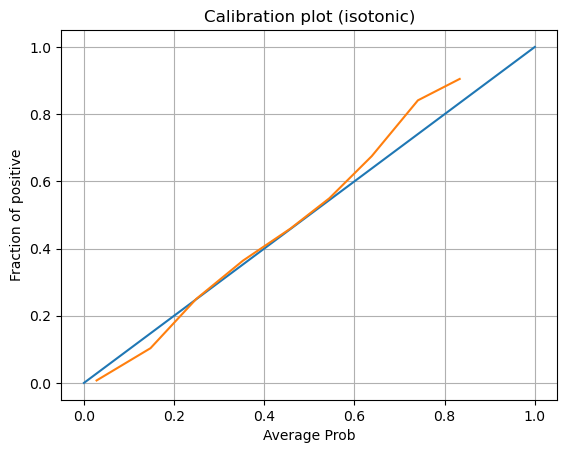

In [137]:
plt.plot([0,1],[0,1])
plt.plot(apv,fop)
plt.grid()
plt.xlabel("Average Prob")
plt.ylabel("Fraction of positive")
plt.title('Calibration plot (isotonic)')
plt.show()
#The calibration is not exactly ideal but pretty-good.

In [138]:
alpha = [0.001,0.01,0.1,1,2,10] #list of alpha values
log_error_array=[]


In [141]:
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(X_train, y_train) #fit SGD
    
    sig_clf = CalibratedClassifierCV(clf, method="isotonic")
    sig_clf.fit(X_train, y_train) #fit CC
    
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataCon

For values of alpha =  0.001 The log loss is: 0.5237384199911652


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataCon

For values of alpha =  0.01 The log loss is: 0.5224232719993863


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataCon

For values of alpha =  0.1 The log loss is: 0.5258287739567851


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataCon

For values of alpha =  1 The log loss is: 0.5325740440458768


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataCon

For values of alpha =  2 The log loss is: 0.5332862929743163


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataCon

For values of alpha =  10 The log loss is: 0.5357751109334534


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2851: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2851: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


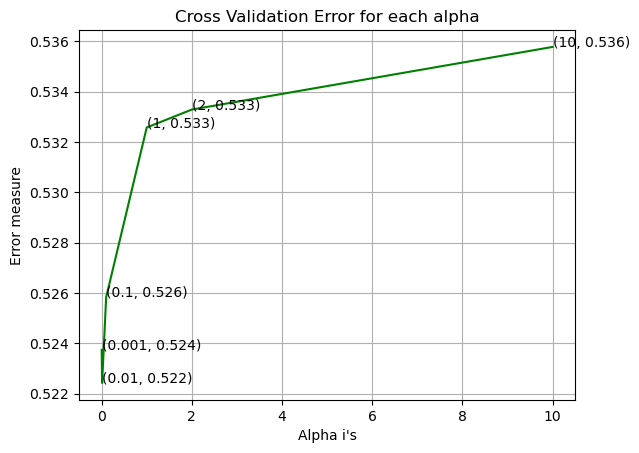

In [142]:
#plot of alpha vs log-loss    
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [144]:

#Pick the index of least log-loss and fit the model on its corresponding alpha.
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_train)
predict_y


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataCon

array([[0.62563458, 0.37436542],
       [0.46743984, 0.53256016],
       [0.273413  , 0.726587  ],
       ...,
       [0.50328809, 0.49671191],
       [0.36824465, 0.63175535],
       [0.90373291, 0.09626709]])

In [145]:
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))

For values of best alpha =  0.01 The train log loss is: 0.5348098609212925
For values of best alpha =  0.01 The test log loss is: 0.533060682541486
Total number of data points : 40342


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2851: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2851: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


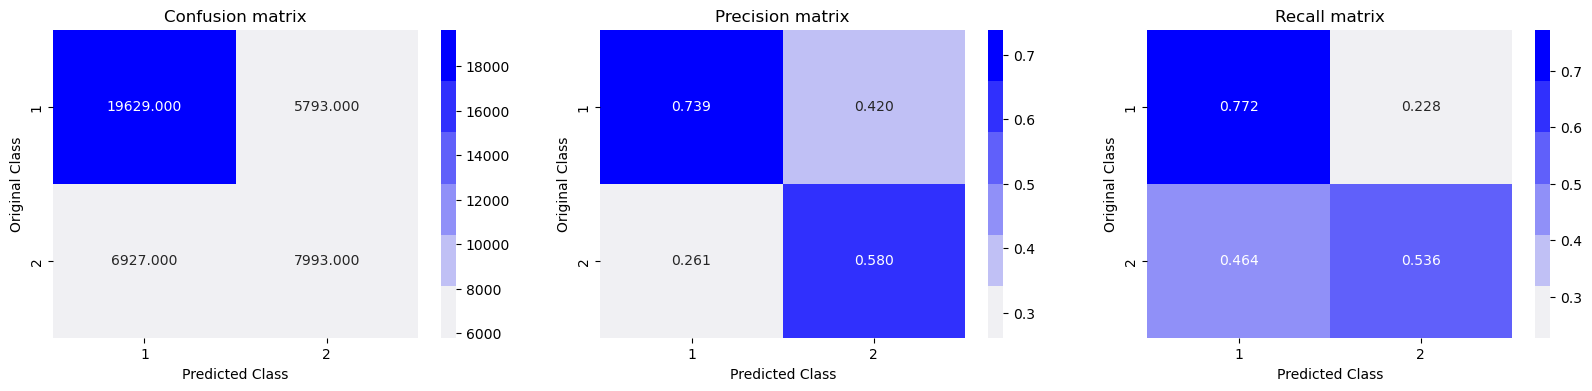

In [146]:

plot_confusion_matrix(y_test, predicted_y)


In [147]:
print(accuracy_score(y_test, predicted_y))

0.6846958504784096


In [149]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76     25422
           1       0.58      0.54      0.56     14920

    accuracy                           0.68     40342
   macro avg       0.66      0.65      0.66     40342
weighted avg       0.68      0.68      0.68     40342



In [150]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


[0]	train-logloss:0.65406	valid-logloss:0.65406


/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	train-logloss:0.61307	valid-logloss:0.61304
[20]	train-logloss:0.58346	valid-logloss:0.58348
[30]	train-logloss:0.56109	valid-logloss:0.56121
[40]	train-logloss:0.54452	valid-logloss:0.54472
[50]	train-logloss:0.53128	valid-logloss:0.53153
[60]	train-logloss:0.52128	valid-logloss:0.52158
[70]	train-logloss:0.51346	valid-logloss:0.51377
[80]	train-logloss:0.50705	valid-logloss:0.50742
[90]	train-logloss:0.50198	valid-logloss:0.50236
[100]	train-logloss:0.49785	valid-logloss:0.49826
[110]	train-logloss:0.49440	valid-logloss:0.49482
[120]	train-logloss:0.49150	valid-logloss:0.49198
[130]	train-logloss:0.48921	valid-logloss:0.48973
[140]	train-logloss:0.48735	valid-logloss:0.48788
[150]	train-logloss:0.48565	valid-logloss:0.48617
[160]	train-logloss:0.48425	valid-logloss:0.48475
[170]	train-logloss:0.48291	valid-logloss:0.48347
[180]	train-logloss:0.48173	valid-logloss:0.48230
[190]	train-logloss:0.48066	valid-logloss:0.48128
[200]	train-logloss:0.47981	valid-logloss:0.48043
[210]	tra

/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2851: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


In [151]:
model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train.values.ravel()) 
prediction = model.predict(X_test)
cm = confusion_matrix(y_test, prediction)  
print(cm)  
print('Accuracy', accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))

/Users/srishtysuman/anaconda3/envs/pytorch/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:29:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[[19970  5452]
 [ 4764 10156]]
Accuracy 0.7467651578999553
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     25422
           1       0.65      0.68      0.67     14920

    accuracy                           0.75     40342
   macro avg       0.73      0.73      0.73     40342
weighted avg       0.75      0.75      0.75     40342



In [152]:
param_grid = {"max_depth":[x for x in range(2,10)],
              "n_estimators":[50,100,150,200,300,400,500]}
from sklearn.model_selection import RandomizedSearchCV
model = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1,random_state=25), param_distributions=param_grid,n_iter=30,scoring='neg_log_loss',cv=3,n_jobs=-1)
model.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=25, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 100, 150, 200, 300,
                                                         400, 500]},
                   scoring='neg_log_loss')

In [153]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=25,max_depth=9,n_estimators=400)
y_pred_test=clf.predict_proba(X_test)
y_pred_train=clf.predict_proba(X_train)
log_loss_train = log_loss(y_train, y_pred_train, eps=1e-15)
log_loss_test=log_loss(y_test,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train,' Test log loss = ',log_loss_test)
predicted_y=np.argmax(y_pred_test,axis=1)
plot_confusion_matrix(y_test,predicted_y)

NotFittedError: need to call fit or load_model beforehand

In [ ]:
print('Accuracy', accuracy_score(y_test, predicted_y))
print(classification_report(y_test, predicted_y))

In [ ]:
result = pickle_model.predict(X_test[:1])
result